The goal of this notebook is to visualise individual activation maps and pools from various layer to get a sense of what's happening inside our model. We are essentially trying to white box the model. This is sort of like "https://adamharley.com/nn_vis/cnn/2d.html" but for CIFAR-10 dataset.

Firstly the imports!
- The entire model runs in numpy python (CPU), but uses vectorised, efficient im2col and pooling operations. 
- itertools is for specialised iteration for certain operation of tensor class
- matplotlib for visualization

In [1]:
import numpy as np
import itertools
from matplotlib import pyplot as plt

This is the entire backbone of our model. 
- Firstly, we have the tensor class. It is a wrapper on numpy array that performs vector operations with child tracking and computational graph.
- Secondly the Conv2d is the 2D convolutional layer with im2col operation. 
- The maxpool2D class is simply the pooling layer class.
- FC (Fully Connected) class is the backbone of fully connected layer.

Note: We dont have batch normalization yet!

In [2]:
class tensor:
    def __init__(self, fromArray=np.zeros((2,2)), _children = (), _operation = ''):
        fromArray = fromArray if isinstance(fromArray, np.ndarray) else np.array(fromArray)
        #assert len(fromArray.shape) == 2, "Only 2D Tensors or Scalar to 2D Supported!"
        self.matrix = fromArray
        #self.rows = fromArray.shape[0]
        #self.columns = fromArray.shape[1]
        self.shape = fromArray.shape
        self._prev = set(_children)
        self._operation = _operation
        self._backward = lambda : None
        self.grad = None


    def __repr__(self):
        return f"Tensor Values = {self.matrix}"
    
    @classmethod
    def zeros(cls, shape, dtype = np.float32):
        t = tensor()
        t.matrix = np.zeros(shape, dtype=dtype)
        t.shape = shape
        return t
    
    @classmethod
    def random(cls, shape, dtype = np.float32):
        t = tensor()
        t.matrix = (np.random.randn(*shape) * 0.1).astype(dtype=dtype)
        t.shape = shape
        return t
    
    @classmethod
    def he_init(cls, shape, fan_in, dtype=np.float32):
        t = tensor()
        std = np.sqrt(2.0 / fan_in)
        t.matrix = (np.random.randn(*shape) * std).astype(dtype=dtype)
        t.shape = shape
        return t
    
    @classmethod
    def const(cls, shape, constant=1, dtype = np.float32):
        t = tensor()
        t.matrix = (np.full(shape, constant)).astype(dtype=dtype)
        t.shape = shape
        return t
    
    #Operations
    def __add__(self, other):
        other = self.checkOther(other)
        out_matrix = self.matrix + other.matrix

        def _backward():
            self.grad = np.zeros_like(self.matrix) if self.grad is None else self.grad
            other.grad = np.zeros_like(other.matrix) if other.grad is None else other.grad
            out1 = self.return_unbroadcasted(out)
            out2 = other.return_unbroadcasted(out)
            self.grad += out1 #Derivation in the notes. 
            other.grad += out2
        out = tensor(out_matrix, (self, other), '+')
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other):
        other = self.checkOther(other)
        return self + (-1 * other)
    
    
    def __rsub__(self, other):
        other = self.checkOther(other)
        return other + (-1 * other)
    

    def __mul__(self, other):
        other = self.checkOther(other)
        out_matrix = self.matrix * other.matrix
        def _backward():
            self.grad = np.zeros_like(out.grad) if self.grad is None else self.grad
            other.grad = np.zeros_like(out.grad) if other.grad is None else other.grad
            out1 = self.return_unbroadcasted(out)
            out2 = other.return_unbroadcasted(out)
            self.grad += out1* other.matrix #Derivation in the notes. 
            other.grad += out2 * self.matrix

        out = tensor(out_matrix, (self, other), '*')
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        other = self.checkOther(other)
        return self*other
    
    '''
    batch multiplication might cause shape broadcasts.
    eg. (3,2,2) @ (1,2,3) = (3,2,3)
    this is similar to our element wise operations
    thus we should be handling this the same way we did for elementwise operations
    But, for now, we would be working in a controlled way (Even for CNNS)
    and wouldn't need this handling.
    '''
    def __matmul__(self, other):
        other = other if isinstance(other, tensor) else tensor(other)
        assert other.shape[-2] == self.shape[-1], "Dimension Unsupported for @"
        out_matrix = self.matrix @ other.matrix
        def _backward():
            self.grad = np.zeros_like(self.matrix) if self.grad is None else self.grad
            other.grad = np.zeros_like(other.matrix) if other.grad is None else other.grad
            self.grad += out.grad @ (other.matrix).swapaxes(-2,-1)#Derivation in the notes.
            other.grad += (self.matrix).swapaxes(-2,-1) @ out.grad 
        out = tensor(out_matrix, (self, other), '@')
        out._backward = _backward
        return out
    

    #I and thus we should learn at this point that to make our class compatible for ND tensors,
    #We need the matrix multiplication and Transpose backward to change
    #For higher dimensions, matmul = batch matmul where multiplication is done 
    #along each and every batches of 2D matrix. 
    #eg. If we have (2,3,3) shape tensor, it implies there are two batches of (3,3) matrices
    #similarly, (2,3,3,2) shape = 2x3 batches of 3x2 matrices.
    #matrix multiplication, (2,3,3) @ (2,3,2) = (2,3,2)
    def swap_axes(self, axis1, axis2):
        out_matrix = self.matrix.swapaxes(axis1, axis2)
        
        def _backward():
            self.grad = np.zeros_like(out.grad.swapaxes(axis1,axis2)) if self.grad is None else self.grad
            self.grad += (out.grad).swapaxes(axis1,axis2) #Not in note, but can be derived similarly.

        out = tensor(out_matrix, (self, ), 'T')
        out._backward = _backward

        return out

    def transpose(self):
        out_matrix = self.matrix.transpose()
        
        def _backward():
            self.grad = np.zeros_like(out.grad.transpose()) if self.grad is None else self.grad
            self.grad += (out.grad).transpose() #Not in note, but can be derived similarly.

        out = tensor(out_matrix, (self, ), 'T')
        out._backward = _backward

        return out
    
    def __rmatmul__(self, other):
        other = other if isinstance(other, tensor) else tensor(other)
        return other @ self
    
    def __pow__(self, N):
        assert isinstance(N, int | float), "Can only power up by scalars!"
        out_matrix = self.matrix ** N

        def _backward():
            self.grad = np.zeros_like(self.matrix) if self.grad is None else self.grad
            out1 = self.return_unbroadcasted(out)
            self.grad += N * (self.matrix ** (N-1)) * out1
        
        out = tensor(out_matrix, _children=(self, ), _operation="**")
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        other = self.checkOther(other)
        return self * (other**-1)
    
    def __rtruediv__(self, other):
        return other * (self**-1)
    
    def sum(self):
        out_matrix = np.array(([[self.matrix.sum()]]))

        def _backward():
            self.grad = np.zeros_like(self.matrix) if self.grad is None else self.grad
            self.grad += np.ones_like(self.matrix) * out.grad

        out = tensor(out_matrix, _children=(self, ), _operation='sum()')
        out._backward = _backward
        return out

    def mean(self):
        N = np.prod(self.shape)
        out_matrix = np.array(([[self.matrix.sum()/(N)]]))

        def _backward():
            self.grad = np.zeros_like(self.matrix) if self.grad is None else self.grad
            self.grad += np.ones_like(self.matrix) * out.grad / N

        out = tensor(out_matrix, _children=(self, ), _operation='mean()')
        out._backward = _backward
        return out
    
    def ReLU(self):
        out_matrix = np.maximum(0,self.matrix)

        def _backward():
            self.grad = np.zeros_like(self.matrix) if self.grad is None else self.grad
            self.grad += (self.matrix > 0).astype(self.matrix.dtype) * out.grad

        out = tensor(out_matrix, (self, ), "ReLU")
        out._backward = _backward
        return out
    
    def reshape(self, shape):
        assert isinstance(shape, tuple), f"Can only reshape using shape tuples e.g. (3,3). Provided is {shape}"
        out_matrix = self.matrix.reshape(shape)

        def _backward():
            self.grad = np.zeros_like(self.matrix) if self.grad is None else self.grad
            self.grad += out.grad.reshape(self.shape)

        out = tensor(out_matrix, (self, ), "reshape()")
        out._backward = _backward
        return out
    
    def flatten(self):
        out_matrix = self.matrix.reshape(-1,np.prod(self.shape[1:]))

        def _backward():
            self.grad = np.zeros_like(self.matrix) if self.grad is None else self.grad
            self.grad += out.grad.reshape(self.shape)

        out = tensor(out_matrix, (self, ), "flatten()")
        out._backward = _backward
        return out
    
    #Helper Functions
    #def shape(self):
     #   return (self.rows, self.columns)

    def return_unbroadcasted(self, out):  
        added_axis = []
        stretched_axis = []
        for index, (first_no, second_no) in enumerate(itertools.zip_longest(reversed(self.shape), reversed(out.shape))):
            if first_no is None:
                added_axis.append(index)
            elif (first_no == 1) and (second_no > 1):
                stretched_axis.append(index)
        grad = out.grad
        ndim = len(out.shape)
        if stretched_axis:
            original_axes = tuple(ndim - 1 - i for i in stretched_axis)
            grad = np.sum(grad, axis=original_axes, keepdims=True)
        if added_axis:
            original_axes = tuple(ndim - 1 - i for i in added_axis)
            grad = np.sum(grad, axis=original_axes, keepdims=False)
        return grad

    def checkOther(self, other):
        if isinstance(other, int | float):
            other = tensor.const(self.shape, other)
        elif not isinstance(other, tensor):
            other = tensor(other)
        #assert other.shape == self.shape, "Operand Tensor sizes dont match"

        return other
    
    def zero_grad(self):
        self.grad = None
        
    def backward(self):
        self.grad = np.ones_like(self.matrix, dtype=float)
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        for current in reversed(topo):

            current._backward()

    def exp(self):
        out_matrix = np.exp(self.matrix)
        
        def _backward():
            self.grad = np.zeros_like(self.matrix) if self.grad is None else self.grad
            self.grad += out_matrix * out.grad  
        
        out = tensor(out_matrix, (self,), 'exp')
        out._backward = _backward
        return out
    
    def log(self, eps=1e-8):
        clipped = np.clip(self.matrix, eps, None)  
        out_matrix = np.log(clipped)
        
        def _backward():
            self.grad = np.zeros_like(self.matrix) if self.grad is None else self.grad
            self.grad += (1.0 / clipped) * out.grad 
        
        out = tensor(out_matrix, (self,), 'log')
        out._backward = _backward
        return out
    
    def softmax(self, axis=-1):
        out_matrix = np.exp(self.matrix) / np.sum(np.exp(self.matrix), axis = axis, keepdims=True)

        def _backward():
            self.grad = np.zeros_like(self.matrix) if self.grad is None else self.grad
            self.grad += out_matrix*(out.grad - np.sum(out_matrix * out.grad, axis = axis, keepdims=True))

        out = tensor(out_matrix, (self, ), 'softmax')
        out._backward = _backward
        return out

    __array_ufunc__ = None

In [3]:
class Conv2d:
    def __init__(self, in_channels=1, out_channels=1, kernel_size=2, stride=1):
        self.kernel = tensor.random((out_channels, in_channels, kernel_size, kernel_size))
        #fan_in = in_channels * kernel_size * kernel_size
        #self.kernel = tensor.he_init((out_channels, in_channels, kernel_size, kernel_size), fan_in)
        self.bias = tensor.zeros((out_channels, ))
        self.kernel_size = kernel_size
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.stride = stride

    def parameters(self):
        return [self.kernel, self.bias]

    def __call__(self, X : tensor):

        batch_size = X.shape[0]

        X_col, act_h, act_w = Conv2d.im2col(X, kernel_size=self.kernel_size, stride=self.stride)
        K_col_shape = (self.out_channels, self.kernel_size*self.kernel_size*self.in_channels)
        K_col = self.kernel.reshape(K_col_shape).transpose()
        Y_col = X_col @ K_col + self.bias
        Y = Y_col.reshape((batch_size, self.out_channels, act_h, act_w))
        return Y
        
    @classmethod
    def im2col(cls, X : tensor, kernel_size=2, stride=1):

        batch_size = X.shape[0]
        channels = X.shape[1]
        image_height = X.shape[-2] #Rows
        image_width = X.shape[-1] #Columns

        #We are assuming square kernels.
        kernel_h = kernel_size
        kernel_w = kernel_size

        act_h = (((image_height - kernel_size)//stride) + 1) #height of activation
        act_w = (((image_width - kernel_size)//stride) + 1)  #width of activation

        istrides = X.matrix.strides #strides of input tensor

        intermediate_6D = np.lib.stride_tricks.as_strided(
                            X.matrix,
                            shape=(batch_size, act_h, act_w, channels, kernel_h, kernel_w),
                            strides=(istrides[0], #No of images stride bytes
                                     istrides[-2] * stride, #Activation map Vertical stride bytes
                                     istrides[-1] * stride, #Activation map Horizontal stride bytes
                                     istrides[1], #Channel stride bytes
                                     istrides[-2], #Rective field vertical stride bytes
                                     istrides[-1]) #Receptive field horizontal stride bytes
                            )
        
        out_shape = (batch_size * act_h * act_w, channels * kernel_h * kernel_w)
        out_matrix = np.reshape(intermediate_6D, shape=out_shape)


        def _backward():
            X.grad = np.zeros_like(X.matrix) if X.grad is None else X.grad
            
            grad_6D = out.grad.reshape(batch_size, act_h, act_w, channels, kernel_h, kernel_w)
            for i in range(kernel_h):
                for j in range(kernel_w):
                    grad_slice = grad_6D[:, :, :, :, i, j]
                    
                    grad_slice_transposed = grad_slice.transpose(0, 3, 1, 2)
                    X.grad[:, :, 
                        i : i + act_h * stride : stride, 
                        j : j + act_w * stride : stride
                    ] += grad_slice_transposed

        out = tensor(out_matrix, _children=(X, ), _operation='im2col')

        out._backward = _backward

        return out, act_h, act_w

In [4]:
class maxpool2D:
    def __init__(self, in_channels, pool_size = 2, stride = 1):
        self.in_channels = in_channels
        self.pool_size = pool_size
        self.stride = stride


    def __call__(self, Y: tensor):

        batch_number = Y.shape[0]
        filters = Y.shape[1]
        image_height = Y.shape[-2] #Rows
        image_width = Y.shape[-1] #Columns


        #We are assuming square kernels.
        pool_h = self.pool_size
        pool_w = self.pool_size

        pooled_h = (((image_height - pool_h)//self.stride) + 1) #height of activation
        pooled_w = (((image_width - pool_w)//self.stride) + 1)  #width of activation

        istrides = Y.matrix.strides #strides of input tensor

        intermediate_6D = np.lib.stride_tricks.as_strided(
                            Y.matrix,
                            shape=(batch_number, pooled_h, pooled_w, filters, pool_h, pool_w),
                            strides=(istrides[0], #No of images stride bytes
                                     istrides[-2] * self.stride, #Activation map Vertical stride bytes
                                     istrides[-1] * self.stride, #Activation map Horizontal stride bytes
                                     istrides[1], #Channel stride bytes
                                     istrides[-2], #Rective field vertical stride bytes
                                     istrides[-1]) #Receptive field horizontal stride bytes
                            )
        
        intermediate_6D_transposed = intermediate_6D.transpose(0, 3, 1, 2, 4, 5)
        intermediate_5D = intermediate_6D_transposed.reshape(batch_number, filters, pooled_h, pooled_w, pool_h * pool_w)

        out_matrix = np.max(intermediate_5D, axis=-1)
        IndexA_for5D = np.argmax(intermediate_5D, axis=-1)

        def _backward():
            # Recover window position (i, j) from flat index in last dim
            Y.grad = np.zeros_like(Y.matrix) if Y.grad is None else Y.grad
            flat_idx = IndexA_for5D  # (B, F, pooled_h, pooled_w)
            i = flat_idx // pool_w
            j = flat_idx % pool_w

            # Build grids for batch, filter, and pooled positions
            b_grid = np.arange(batch_number).reshape(batch_number, 1, 1, 1)
            f_grid = np.arange(filters).reshape(1, filters, 1, 1)
            ph_grid = np.arange(pooled_h).reshape(1, 1, pooled_h, 1)
            pw_grid = np.arange(pooled_w).reshape(1, 1, 1, pooled_w)

            # Broadcast all to shape (B, F, pooled_h, pooled_w)
            b_idx = np.broadcast_to(b_grid, flat_idx.shape)
            f_idx = np.broadcast_to(f_grid, flat_idx.shape)
            ph = np.broadcast_to(ph_grid, flat_idx.shape)
            pw = np.broadcast_to(pw_grid, flat_idx.shape)

            # Compute actual positions in Y where max values came from
            h_idx = self.stride * ph + i
            w_idx = self.stride * pw + j

            # Accumulate gradients using 4D indexing
            np.add.at(Y.grad, (b_idx.ravel(), f_idx.ravel(), h_idx.ravel(), w_idx.ravel()), out.grad.ravel())

        out = tensor(out_matrix, _children=(Y, ), _operation="maxpool")
        out._backward = _backward

        return out

In [5]:
class FC:
    def __init__(self, in_features, out_features):
        
        self.bias = tensor.zeros((out_features, 1))
        # He initialization: fan_in = in_features
        #self.weights = tensor.he_init((out_features, in_features), in_features)
        self.weights = tensor.random((out_features, in_features))

    def parameters(self):
        return [self.weights, self.bias]

    def __call__(self, X:tensor):
        return (self.weights @ X) + self.bias

In [54]:
class CNN:
    def __init__(self, in_channels, layers, kernels_in_layers, kernels_shape, conv_strides, pool_shape, pool_strides, FCL_weights):
        self.in_channels = (in_channels, ) + kernels_in_layers
        self.FCL_weights = FCL_weights
        self.layers = layers
        self.conv_layers = [Conv2d(self.in_channels[layer], kernels_in_layers[layer], kernels_shape[layer], conv_strides[layer]) for layer in range(layers)]
        self.pool_layers = [maxpool2D(kernels_in_layers[layer], pool_shape[layer], pool_strides[layer]) for layer in range(layers)]
        self.FC_layers = [None for _ in range(layers+1)]

    def parameters(self):
        params = []
        for layer in range(self.layers):
            params.extend(self.conv_layers[layer].parameters())
            params.extend(self.FC_layers[layer].parameters())
        params.extend(self.FC_layers[layer+1].parameters())
        return params

    def __call__(self, X:tensor):
        b = X
        for layer in range(self.layers):
            a_ = self.conv_layers[layer](b)
            a = a_.ReLU()
            b = self.pool_layers[layer](a)
        
        c:tensor = b.reshape((X.shape[0], -1)).transpose()
        if self.FC_layers[0] is None:
            self.FC_layers[0] = FC(c.shape[0], self.FCL_weights[0])

        for layer in range(self.layers+1):
            if self.FC_layers[layer] is None:
                self.FC_layers[layer] = FC(self.FCL_weights[layer-1], self.FCL_weights[layer])

            c = self.FC_layers[layer](c)
            
            if layer < self.layers:
                c = c.ReLU()
        
        out = c.transpose()
        return out
    
    @classmethod
    def cross_entropy_loss(cls, ypredicted: tensor, ytrue, batch_size):
        ytrue =  tensor(ytrue) if not isinstance(ytrue, tensor) else ytrue
        ypredicted = ypredicted.softmax(axis=-1)
        cross_entropy = -1 * ypredicted.log()
        #loss = ((ytrue * cross_entropy).sum())/batch_size
        loss = ((ytrue * cross_entropy).sum())
        return loss

    def fit(self, X_train, y_train, epochs = 10, lr = 0.001, batch_size = 32):
        lossT = []
        for epoch in range(epochs):
            epoch_loss = 0.0
            n_batches = 0
            perm = np.random.permutation(len(X_train))
            for i in range(0, len(X_train), batch_size):
                idx = perm[i:i+batch_size]
                xb = tensor(X_train[idx])             
                yb = tensor(y_train[idx]) 

                y_predicted = self(xb)
                ce_loss = CNN.cross_entropy_loss(y_predicted, yb, len(idx))
                ce_loss.backward()

                for param in self.parameters():
                    if param.grad is not None:

                        grad_clipped = np.clip(param.grad, -1.0, 1.0)
                        param.matrix -= lr * grad_clipped
                        param.grad = None
                
                epoch_loss += ce_loss.matrix.flatten()[0]
                n_batches += 1
            
            avg_loss = epoch_loss / n_batches    
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")
            lossT.append((epoch, avg_loss))

        return lossT

Now let's prepare the CIFAR-10 dataset.
1. Load dataset
2. Normalise training images
3. Encode classes

In [29]:
import os
os.environ['KERAS_BACKEND'] = 'jax'
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.transpose(0, 3, 1, 2).astype(np.float32) / 255.0  
X_test = X_test.transpose(0, 3, 1, 2).astype(np.float32) / 255.0
Y_train = np.zeros((y_train.size, 10))
Y_train[np.arange(y_train.size), y_train.flatten()] = 1
Y_test = np.zeros((y_test.size, 10))
Y_test[np.arange(y_test.size), y_test.flatten()] = 1

/Users/pawanadhikari/Documents/Roadmap/MachineLearningMaths/.venv/lib/python3.14/site-packages/keras/src/datasets/cifar.py:18: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  d = cPickle.load(f, encoding="bytes")


Shapes for reference.

In [9]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(50000, 1, 32, 32, 3)
(50000, 10)
(10000, 1, 32, 32, 3)
(10000, 10)


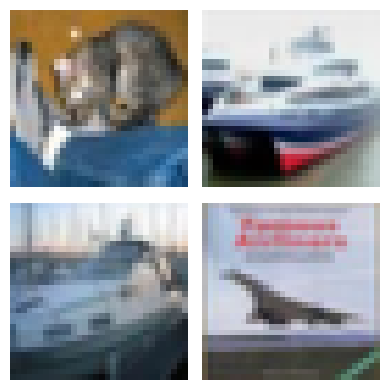

In [39]:
#Showing first 4 images.
'''
for image in X_test[:4]:
    image = image.transpose(1,2,0)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
'''
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(4, 4))
ax[0,0].imshow(X_test[0].transpose(1,2,0))
ax[0,0].axis('off')
ax[0,1].imshow(X_test[1].transpose(1,2,0))
ax[0,1].axis('off')
ax[1,0].imshow(X_test[2].transpose(1,2,0))
ax[1,0].axis('off')
ax[1,1].imshow(X_test[3].transpose(1,2,0))
ax[1,1].axis('off')
plt.tight_layout()
plt.show()



And let's see the outputs now!

In [30]:
y_test[:10]

array([[3],
       [8],
       [8],
       [0],
       [6],
       [6],
       [1],
       [6],
       [3],
       [1]], dtype=uint8)

After Encoding:

In [31]:
Y_test[:10]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

Now, Let us train a simple CNN for this dataset.

In [ ]:
model = CNN(
    in_channels=3,
    layers=3,
    kernels_in_layers= (5, 16, 32, ),
    kernels_shape= (5, 5, 5, ),
    conv_strides= (1, 1, 1, ),
    pool_shape= (2, 2, 2, ),
    pool_strides= (2, 2, 2, ), 
    FCL_weights= (128, 64, 32, 10) #4 Fully Connected Layers including one output layer. 
)

#We will be training on 1/10th of the total dataset.
loss = model.fit(X_train[:5000], Y_train[:5000], epochs=50, lr=0.01, batch_size=32)

#Plot Train Loss vs Epochs graph.
epochs, losses = zip(*loss)
plt.plot(epochs, losses)
plt.show()


Epoch 1/50, Loss: 73.366431
Epoch 2/50, Loss: 73.368866
Epoch 3/50, Loss: 73.359033
Epoch 4/50, Loss: 73.375842
Epoch 5/50, Loss: 73.369964
Epoch 6/50, Loss: 73.367862
Epoch 7/50, Loss: 73.358166
Epoch 8/50, Loss: 73.368623
Epoch 9/50, Loss: 73.370668
